# Data Modeling Assignment
### Brayan Gutierrez, Katie To, Jericka Ledezma
***

## Logistic Regression Model
### Created by: Katie To
referenced: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8, 
https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
***

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### Data Reading and Extracting

In [2]:
# Reading Dataset
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()

ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns

In [3]:
# Outlier Treatment

for num in numeric:
    Q1 = ground_water_df[num].quantile(0.25)
    Q3 = ground_water_df[num].quantile(0.75)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 -(whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    ground_water_df[num]=np.where(ground_water_df[num]>upper_whisker,upper_whisker,np.where(ground_water_df[num]<lower_whisker,lower_whisker,ground_water_df[num]))

In [4]:
# Standardizing Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ground_water_df[numeric])

ground_water_df[numeric] = scaled_data

ground_water_df[numeric].info()

<class 'pandas.core.frame.DataFrame'>
Index: 817 entries, 0 to 1023
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sno       817 non-null    float64
 1   lat_gis   817 non-null    float64
 2   long_gis  817 non-null    float64
 3   RL_GIS    817 non-null    float64
 4   pH        817 non-null    float64
 5   E.C       817 non-null    float64
 6   TDS       817 non-null    float64
 7   CO3       817 non-null    float64
 8   HCO3      817 non-null    float64
 9   Cl        817 non-null    float64
 10  F         817 non-null    float64
 11  NO3       817 non-null    float64
 12  SO4       817 non-null    float64
 13  Na        817 non-null    float64
 14  K         817 non-null    float64
 15  Ca        817 non-null    float64
 16  Mg        817 non-null    float64
 17  T.H       817 non-null    float64
 18  SAR       817 non-null    float64
 19  RSC       817 non-null    float64
dtypes: float64(20)
memory usage: 134.0 K

In [5]:
# Extracting Chosen Feature to Dataframe
working_gw_df = ground_water_df[['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'mandal', 'village', 'Classification.1']]
working_gw_df = working_gw_df.replace('MR', 'U.S.')

# Changing the Classification.1 to Numeric Valyes (P.S. = 0, U.S. = 1)
le = LabelEncoder()
working_gw_df['Classification.1']= le.fit_transform(working_gw_df['Classification.1']) 

# One-hot encode 'mandal' and 'village' columns separately
mandal_dummies = pd.get_dummies(working_gw_df['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(working_gw_df['village'], prefix='village')

# Concatenate the encoded columns with the original DataFrame
working_gw_df_encoded = pd.concat([working_gw_df.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)

# Display the modified DataFrame
working_gw_df_encoded.head()

,RSC,SAR,Na,E.C,TDS,HCO3,pH,Classification.1,mandal_Abdullapurmet,mandal_Achampet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-0.585459,-0.280348,-0.183791,-0.006796,-0.005646,-0.157500,0.558173,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.496198,-1.025176,-1.198847,-1.738824,-1.739070,-1.777157,0.959698,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.494650,0.665784,0.287996,-0.227203,-0.226629,0.780196,0.440077,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.579402,0.196073,0.087844,-0.074755,-0.074524,0.353971,0.487315,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.003028,-0.300479,-0.198087,0.075856,0.074711,0.439216,0.723507,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Splitting Data
X = working_gw_df_encoded.drop(['Classification.1'], axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [7]:
# parameter finetuning with grid search
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_res, y_train_res)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.998506 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998506 (0.003809) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998506 (0.003809) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.997761 (0.005335) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.998506 (0.003809) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998506 (0.003809) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.997391 (0.005549) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.995531 (0.007406) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.995531 (0.007406) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.992909 (0.008902) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.991040 (0.009770) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.991040 (0.009770) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.976833 (0.015587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.976825 (0.014773) wit

In [8]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train_res)

In [9]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy of Logistic Regression classifier: {:.2f}'.format(accuracy))

Accuracy of Logistic Regression classifier: 0.97


Correctly Classified: 317
Incorrectly Classified: 10


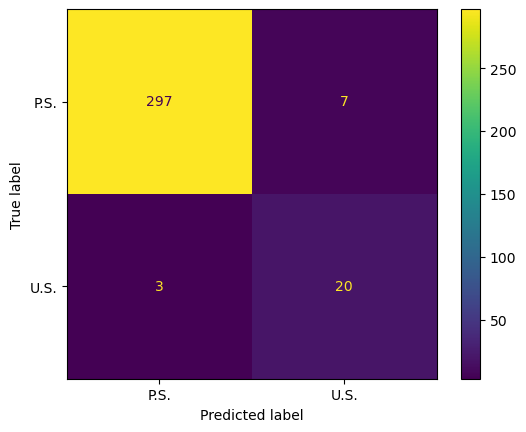

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['P.S.', 'U.S.'])
disp.plot().figure_.savefig('LOG_CM.png')
correct = cm[0][0] + cm[1][1]
incorrect = cm[0][1] + cm [1][0]
print('Correctly Classified:', correct)
print('Incorrectly Classified:', incorrect)

In [11]:
# Classification Report
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train_res, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       304
           1       0.74      0.87      0.80        23

    accuracy                           0.97       327
   macro avg       0.87      0.92      0.89       327
weighted avg       0.97      0.97      0.97       327

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       446
           1       1.00      1.00      1.00       446

    accuracy                           1.00       892
   macro avg       1.00      1.00      1.00       892
weighted avg       1.00      1.00      1.00       892



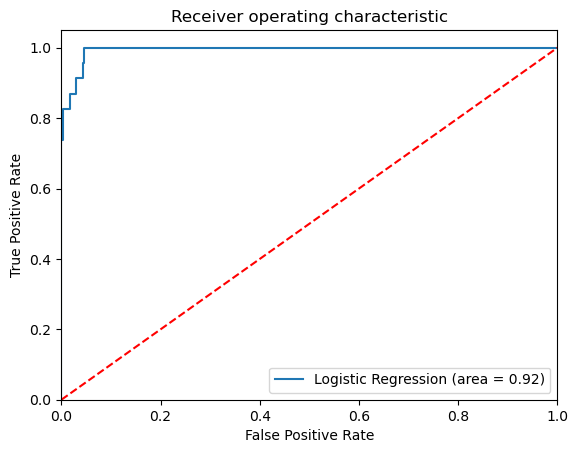

In [12]:
# ROC Curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Decision Tree Model
### Created by: Jericka Ledezma
***

In [13]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import cross_val_score,cross_val_predict, StratifiedKFold, train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from six import StringIO  
from IPython.display import Image  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydotplus

In [14]:
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()
ground_water_df['Classification.1'] = ground_water_df['Classification.1'].replace('MR', 'U.S.')
print(ground_water_df)

      sno  district       mandal      village  lat_gis  long_gis  RL_GIS  \
0       1  ADILABAD     Adilabad     Adilabad    78.52     19.67   253.0   
1       2  ADILABAD  Bazarhatnur  Bazarhatnur    78.35     19.46   435.0   
2       3  ADILABAD         Bela   Chandpally    78.85     19.68   247.0   
3       4  ADILABAD     Bheempur         Arli    78.38     19.83   224.0   
4       5  ADILABAD     Bheempur     Bheempur    78.42     19.77   245.0   
...   ...       ...          ...          ...      ...       ...     ...   
1019   31   YADADRI    Valigonda   T. somaram    78.95     17.40   339.0   
1020   32   YADADRI    Valigonda  Varkatpally    78.93     17.34   339.0   
1021   33   YADADRI    Valigonda  Vemulakonda    79.14     17.35   265.0   
1022   34   YADADRI      Y.Gutta   Mallapuram    78.91     17.63   439.0   
1023   35   YADADRI      Y.Gutta   Motakondur    79.03     17.55   342.0   

                 season    pH     E.C  ...    SO4     Na     K     Ca    Mg  \
0     Po

In [15]:
ground_water_df['pH'] = pd.to_numeric(ground_water_df['pH'], errors='coerce')
ground_water_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 817 entries, 0 to 1023
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sno               817 non-null    int64  
 1   district          817 non-null    object 
 2   mandal            817 non-null    object 
 3   village           817 non-null    object 
 4   lat_gis           817 non-null    float64
 5   long_gis          817 non-null    float64
 6   RL_GIS            817 non-null    float64
 7   season            817 non-null    object 
 8   pH                817 non-null    float64
 9   E.C               817 non-null    float64
 10  TDS               817 non-null    float64
 11  CO3               817 non-null    float64
 12  HCO3              817 non-null    float64
 13  Cl                817 non-null    float64
 14  F                 817 non-null    float64
 15  NO3               817 non-null    float64
 16  SO4               817 non-null    float64
 17  N

In [16]:
ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns
cv = StratifiedKFold
ground_water_df.head()

,sno,district,mandal,village,lat_gis,long_gis,RL_GIS,season,pH,E.C,...,SO4,Na,K,Ca,Mg,T.H,SAR,Classification,RSC,Classification.1
0,1,ADILABAD,Adilabad,Adilabad,78.52,19.67,253.0,Post-monsoon 2021,8.04,1065.0,...,69.0,85.0,3.0,64.0,53.0,380.0,1.90,C3S1,-3.0,P.S.
1,2,ADILABAD,Bazarhatnur,Bazarhatnur,78.35,19.46,435.0,Post-monsoon 2021,8.21,122.0,...,9.0,14.0,2.0,8.0,10.0,60.0,0.79,C1S1,-0.4,P.S.
2,3,ADILABAD,Bela,Chandpally,78.85,19.68,247.0,Post-monsoon 2021,7.99,945.0,...,13.0,118.0,3.0,40.0,34.0,240.0,3.31,C3S1,2.0,U.S.
3,4,ADILABAD,Bheempur,Arli,78.38,19.83,224.0,Post-monsoon 2021,8.01,1028.0,...,15.0,104.0,9.0,40.0,49.0,300.0,2.61,C3S1,-0.2,P.S.
4,5,ADILABAD,Bheempur,Bheempur,78.42,19.77,245.0,Post-monsoon 2021,8.11,1110.0,...,13.0,84.0,2.0,72.0,49.0,380.0,1.87,C3S1,-1.6,P.S.


In [17]:
#split dataset in features and target variable

feature_cols = ['RSC', 'SAR', 'T.H', 'Ca', 'Na', 'Mg', 'HCO3', 'mandal', 'village', 'E.C', 'TDS']# , 'RSC meq / L' , 'NO3' */
X = ground_water_df[feature_cols] # Features
y = ground_water_df['Classification.1'] # Target variable (could be 'Classification' or 'Classification.1')
mandal_dummies = pd.get_dummies(X['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(X['village'], prefix='village')

# Perform one-hot encoding using get_dummies() on the 'village' and 'mandal' columns
#X_encoded = pd.get_dummies(X, columns=['village', 'mandal'], drop_first=True)  # Encoding 'village' and 'mandal' columns and dropping the original columns

# Drop the original 'village' and 'mandal' columns from X_encoded
working_gw_df_encoded = pd.concat([X.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)

X = working_gw_df_encoded

working_gw_df_encoded.head()
# Split dataset into training set and test set
#you get to use all data to train model
#check out to use kfold, use accuracy for attribute scoring

,RSC,SAR,T.H,Ca,Na,Mg,HCO3,E.C,TDS,mandal_Abdullapurmet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-3.0,1.90,380.0,64.0,85.0,53.0,230.0,1065.0,682.0,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.4,0.79,60.0,8.0,14.0,10.0,40.0,122.0,78.0,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,3.31,240.0,40.0,118.0,34.0,340.0,945.0,605.0,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.2,2.61,300.0,40.0,104.0,49.0,290.0,1028.0,658.0,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.6,1.87,380.0,72.0,84.0,49.0,300.0,1110.0,710.0,False,...,False,False,False,False,False,False,False,False,False,False


### Outlier Treatment

In [18]:
for num in numeric:
    Q1 = ground_water_df[num].quantile(0.25)
    Q3 = ground_water_df[num].quantile(0.75)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 -(whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    ground_water_df[num]=np.where(ground_water_df[num]>upper_whisker,upper_whisker,np.where(ground_water_df[num]<lower_whisker,lower_whisker,ground_water_df[num]))

In [19]:
num_rows = len(ground_water_df)

for col in ground_water_df.columns:
    cnts = ground_water_df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.999:
        print('{0}: {1:.2f}%'.format(col, top_pct*100))
        print(cnts)
        print()

season: 100.00%
season
Post-monsoon 2021    817
Name: count, dtype: int64

CO3: 100.00%
CO3
0.0    817
Name: count, dtype: int64



### Decision Tree Fitting, Cross Validation, and Evaluation Metric #1 (Confusion Matrices)

In [20]:
# Split the dataset into features (X) and target variable (y)
X =  working_gw_df_encoded
y = ground_water_df['Classification.1']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Decision Tree classifer object
#this is where you specify the depth (change based on chart given in document [3,7,11,15])
clf = DecisionTreeClassifier(max_depth = 15)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
# Create Decision Tree classifer object
#this is where you specify the depth (change based on chart given in document [3,7,11,15])
tree_depth = [3,7,11,15]
exp_matrix =[[],[],[]]
for i in tree_depth:
    clf = DecisionTreeClassifier(max_depth = i)
    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)
    accuracy = cross_val_score(clf, X, y, scoring='accuracy', cv = 5)
    # precision = cross_val_score(clf, X, y, scoring='precision', cv = 5)
    # recall = cross_val_score(clf, X, y, scoring='recall', cv = 5)
    print("Depth for Training: ",i)
    print("Accuracy for Training:",accuracy.mean() * 100)
    # print("Precision:",precision.mean() *100)
    # print("Recall:",recall.mean() *100)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Create the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    print(f"Testing Confusion Matrix Depth {i}:")
    print(conf_matrix)

Depth for Training:  3
Accuracy for Training: 100.0
Testing Confusion Matrix Depth 3:
[[147   0]
 [  0  17]]
Depth for Training:  7
Accuracy for Training: 100.0
Testing Confusion Matrix Depth 7:
[[147   0]
 [  0  17]]
Depth for Training:  11
Accuracy for Training: 100.0
Testing Confusion Matrix Depth 11:
[[147   0]
 [  0  17]]
Depth for Training:  15
Accuracy for Training: 100.0
Testing Confusion Matrix Depth 15:
[[147   0]
 [  0  17]]


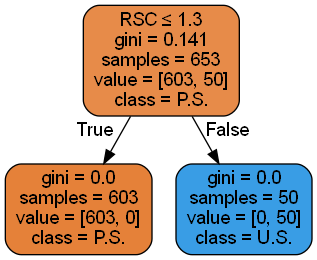

In [21]:
# Get the unique classes in the target variable 'Classification.1'
class_names = y.unique().astype(str)

# Visualize the Decision Tree with the corrected class names
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns, class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ds.png')
Image(graph.create_png())

### Displaying 1 Confusion Matrix

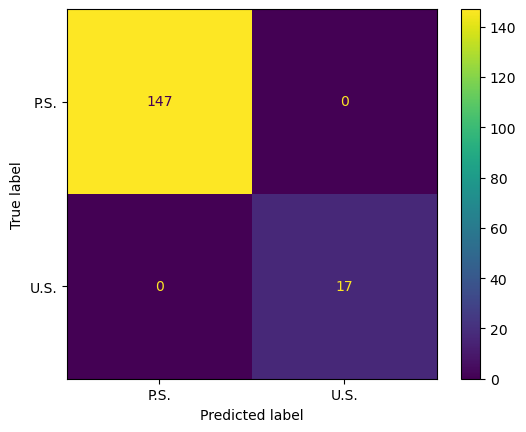

In [22]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["P.S.", 'U.S.'])

cm_display.plot()
plt.savefig('Decision Tree CM.png')
plt.show()

### Evaluation Metric #2: Precision, Recall, and F1 Score

In [23]:
# Assuming 'y_test' and 'y_pred' are the true labels and predicted labels respectively

# Generate a classification report with precision, recall, F1-score, support, and averaging options
report = classification_report(y_test, y_pred, target_names=['P.S.', 'U.S.'], output_dict=True)

# Create a DataFrame from the classification report data
import pandas as pd
classification_df = pd.DataFrame(report).transpose()

# Display the classification report DataFrame
print(classification_df)

              precision  recall  f1-score  support
P.S.                1.0     1.0       1.0    147.0
U.S.                1.0     1.0       1.0     17.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    164.0
weighted avg        1.0     1.0       1.0    164.0


## Random Forest Model
### Created by: Brayan Gutierrez
***

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
import graphviz
import random
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import plot_tree

### Data Reading and Extracting

In [25]:
# Reading Dataset
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()

ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns

# Outlier Treatment
for num in numeric:
    Q1 = ground_water_df[num].quantile(0.25)
    Q3 = ground_water_df[num].quantile(0.75)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 -(whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    ground_water_df[num]=np.where(ground_water_df[num]>upper_whisker,upper_whisker,np.where(ground_water_df[num]<lower_whisker,lower_whisker,ground_water_df[num]))

In [26]:
# Extracting Chosen Feature to Dataframe
chosen = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'mandal', 'village', 'Classification.1']
working_gw_df = ground_water_df[chosen]
working_gw_df = working_gw_df.replace('MR', 'U.S.')

# One-hot encode 'mandal' and 'village' columns separately
mandal_dummies = pd.get_dummies(working_gw_df['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(working_gw_df['village'], prefix='village')

# Concatenate the encoded columns with the original DataFrame
working_gw_df_encoded = pd.concat([working_gw_df.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)
working_gw_df_encoded = working_gw_df_encoded.replace('MR', 'U.S.')

# Display the modified DataFrame
working_gw_df_encoded.head()

,RSC,SAR,Na,E.C,TDS,HCO3,pH,Classification.1,mandal_Abdullapurmet,mandal_Achampet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-3.0,1.90,85.0,1065.0,682.0,230.0,8.04,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.4,0.79,14.0,122.0,78.0,40.0,8.21,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,3.31,118.0,945.0,605.0,340.0,7.99,U.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.2,2.61,104.0,1028.0,658.0,290.0,8.01,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.6,1.87,84.0,1110.0,710.0,300.0,8.11,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False


### Random Forest Algorithm Variants

#### 1. Cross Validating Best Hyperparameters all Features

In [27]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BADB0BEA10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BAE2256D10>})

In [28]:
random.seed(10)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 427}


In [29]:
random.seed(10)
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [30]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9207317073170732


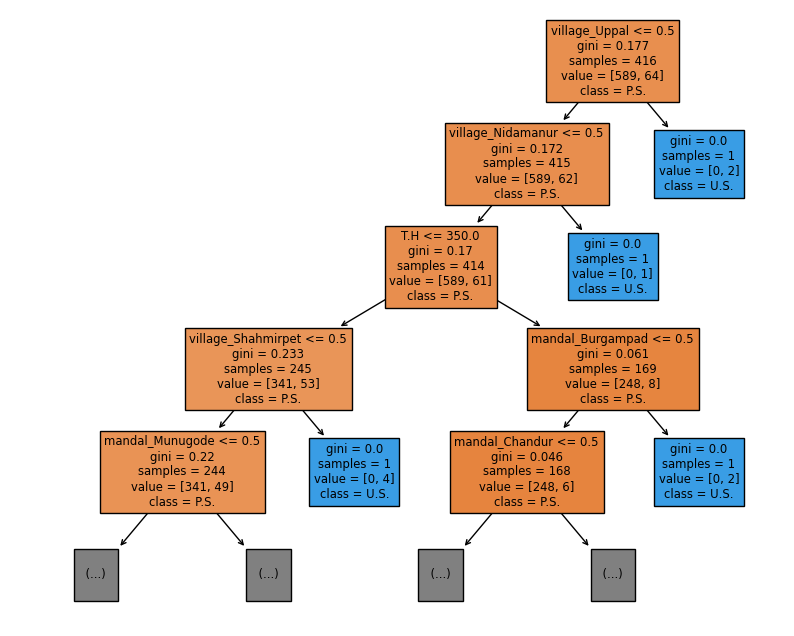

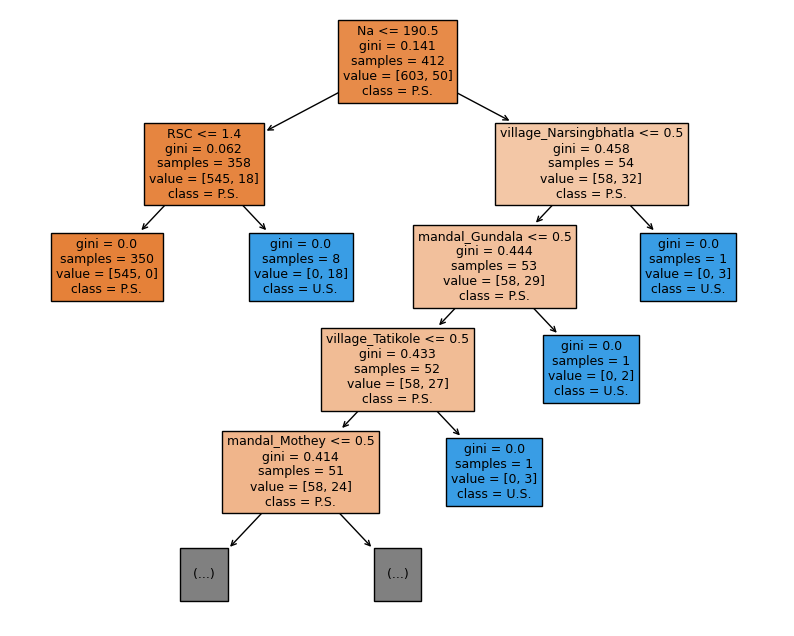

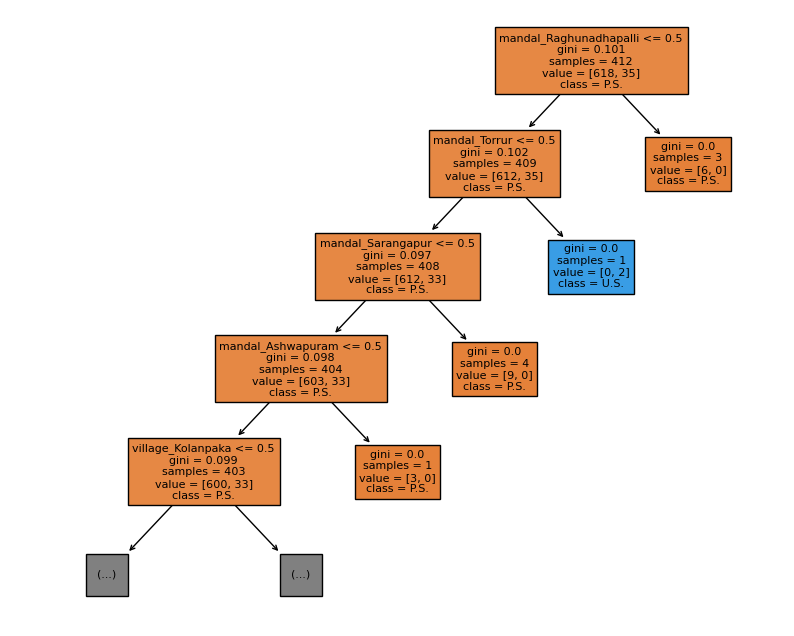

In [31]:
random.seed(10)
for i in range(3):
    tree = rf.estimators_[i]
    
    plt.figure(figsize=(10,8))
    plot_tree(tree, feature_names=list(X_train.columns), class_names=['P.S.', 'U.S.'], filled=True, max_depth=4)
    
    if i == 1:
        plt.savefig('All Feature CV.png')
    
    plt.show()

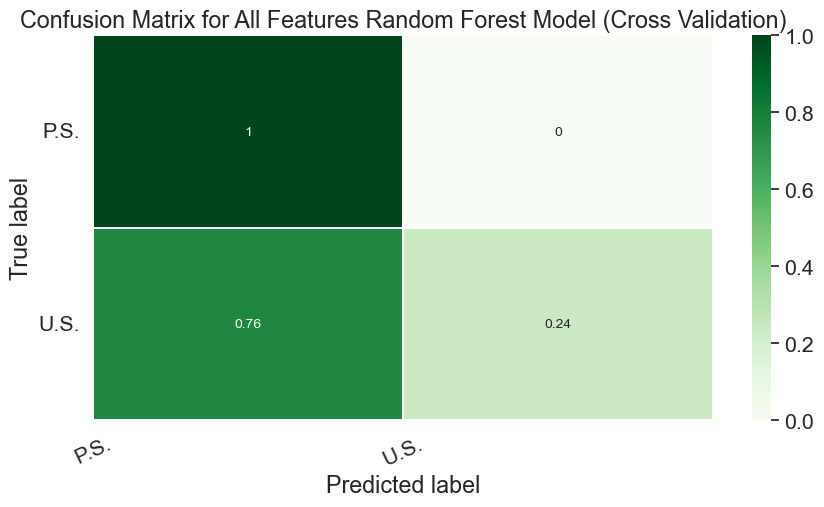

In [32]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (10,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (Cross Validation)')
plt.savefig('Confusion Matrix for All Features Random Forest Model CV.png')
plt.show()

In [33]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.92      1.00      0.96       147
        U.S.       1.00      0.24      0.38        17

    accuracy                           0.92       164
   macro avg       0.96      0.62      0.67       164
weighted avg       0.93      0.92      0.90       164



#### 2. Out of Bag Evaluation All Features

Accuracy: 0.9785932721712538


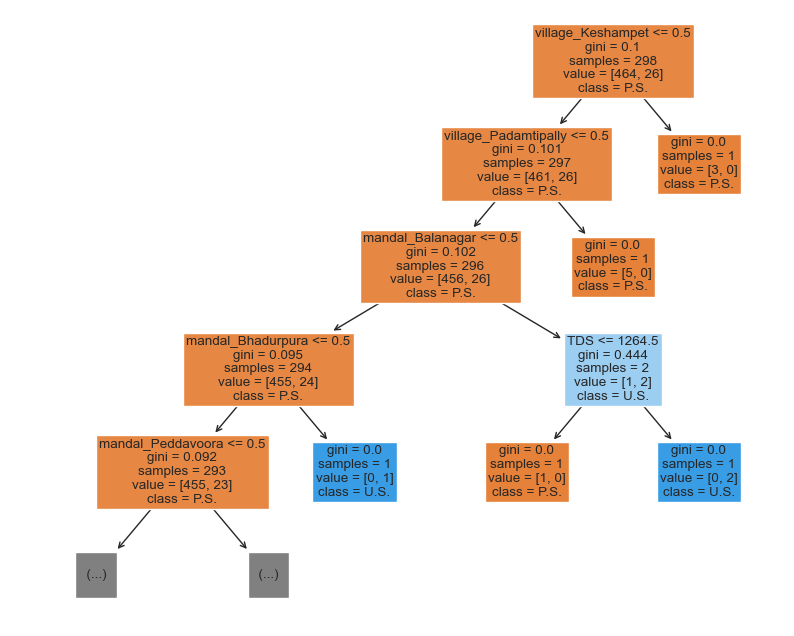

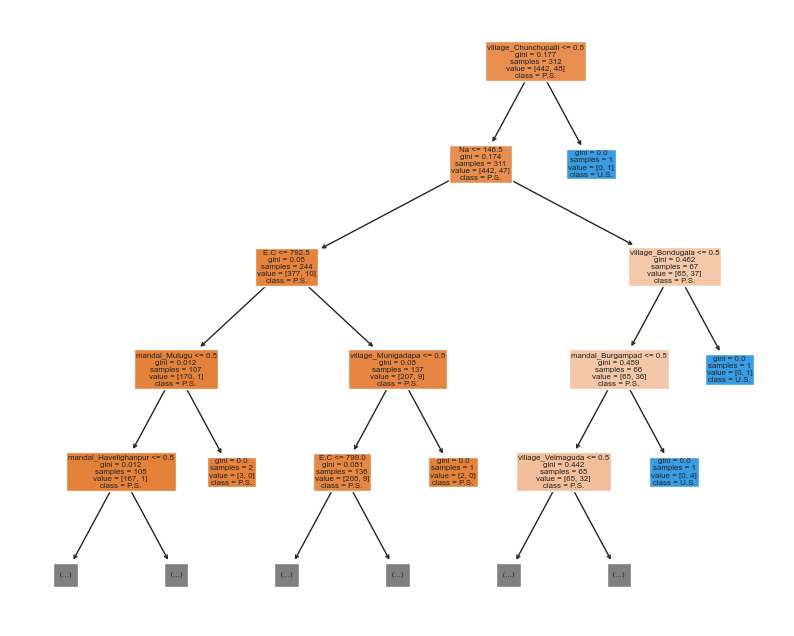

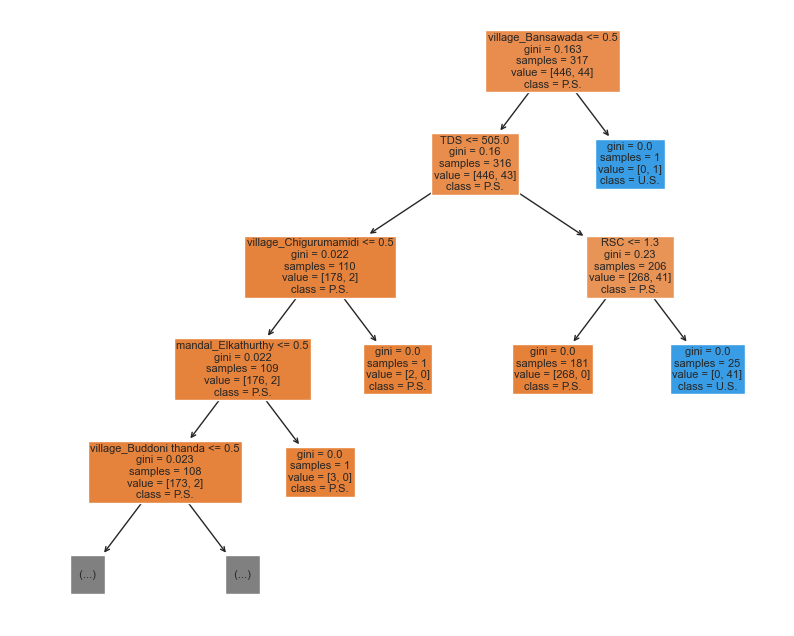

In [34]:
random.seed(10)
# Splitting Data
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    
    plt.figure(figsize=(10,8))
    plot_tree(tree, feature_names=list(X_train.columns), class_names=['P.S.', 'U.S.'], filled=True, max_depth=4)
    
    if i == 1:
        plt.savefig('All Feature OOB.png')
    
plt.show()

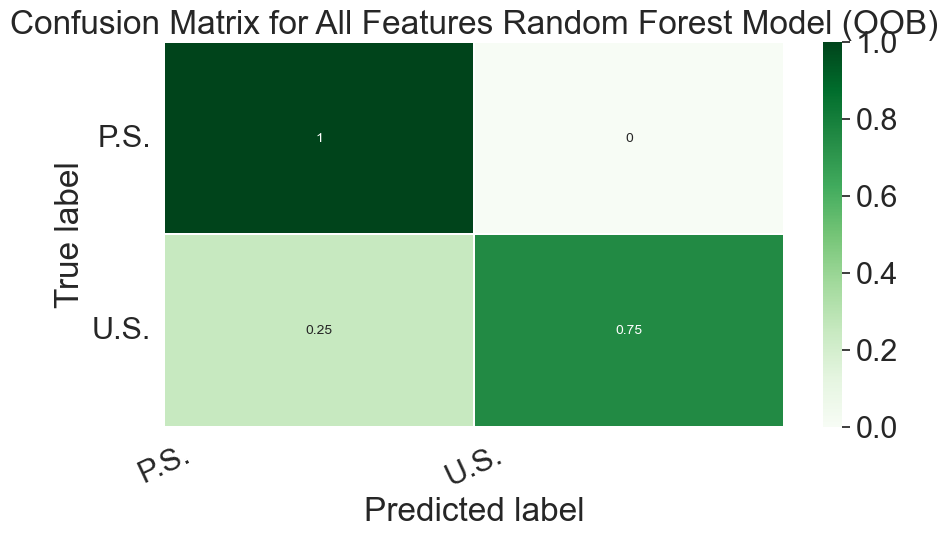

In [35]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (10,5))
sns.set(font_scale = 2)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (OOB)')
plt.savefig('Confusion Matrix for All Features Random Forest Model OOB.png')
plt.show()

In [36]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.98      1.00      0.99       299
        U.S.       1.00      0.75      0.86        28

    accuracy                           0.98       327
   macro avg       0.99      0.88      0.92       327
weighted avg       0.98      0.98      0.98       327



#### 3. Cross Validating Best Hyperparameters Numeric Features

In [37]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 142}


Accuracy: 0.963302752293578


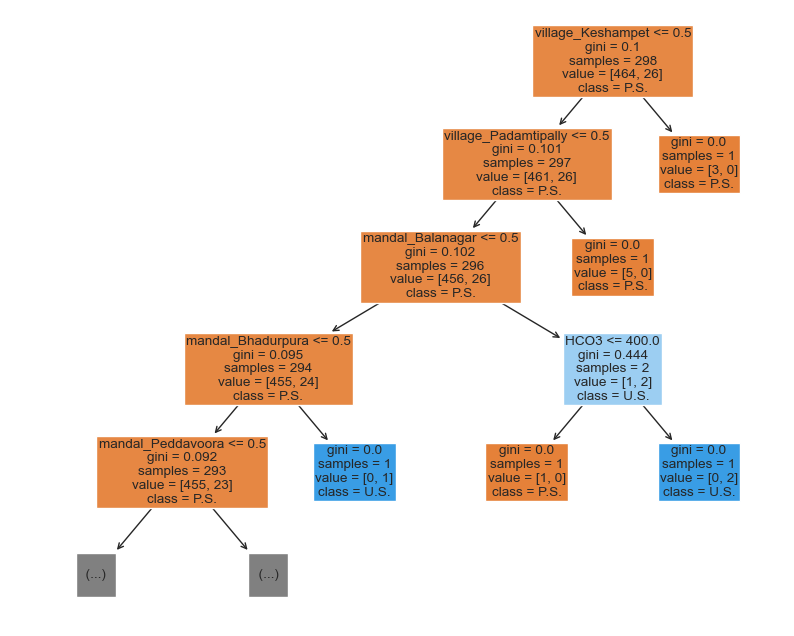

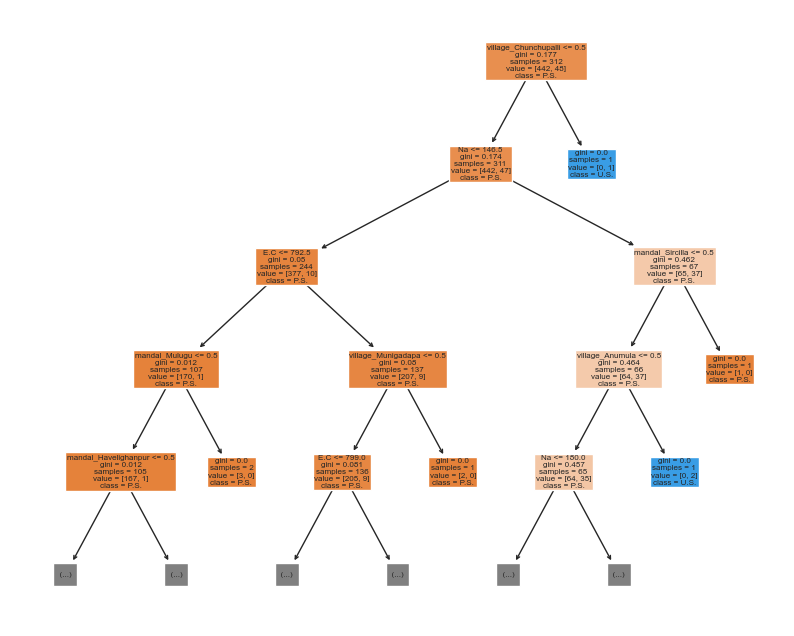

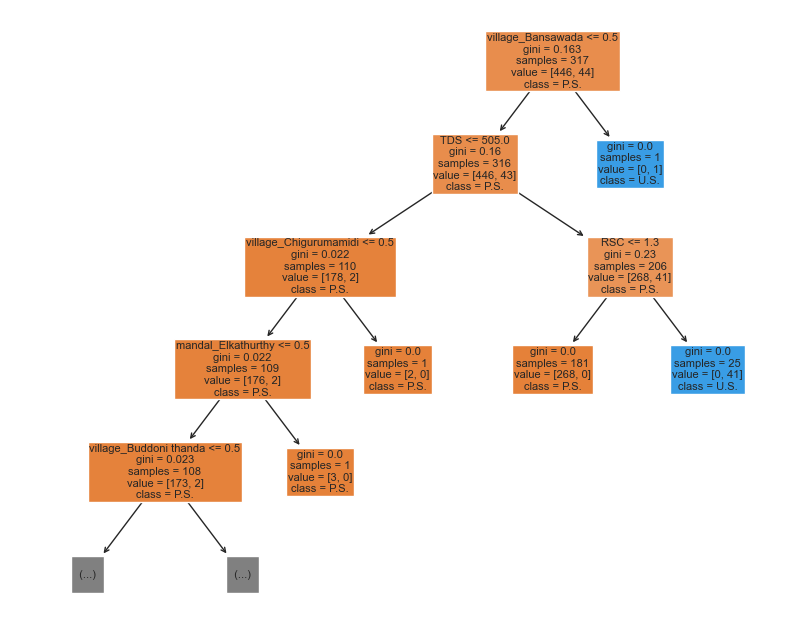

In [38]:
random.seed(10)
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    
    plt.figure(figsize=(10,8))
    plot_tree(tree, feature_names=list(X_train.columns), class_names=['P.S.', 'U.S.'], filled=True, max_depth=4)
    
    if i == 1:
        plt.savefig('Numeric Features CV.png')
    
    plt.show()

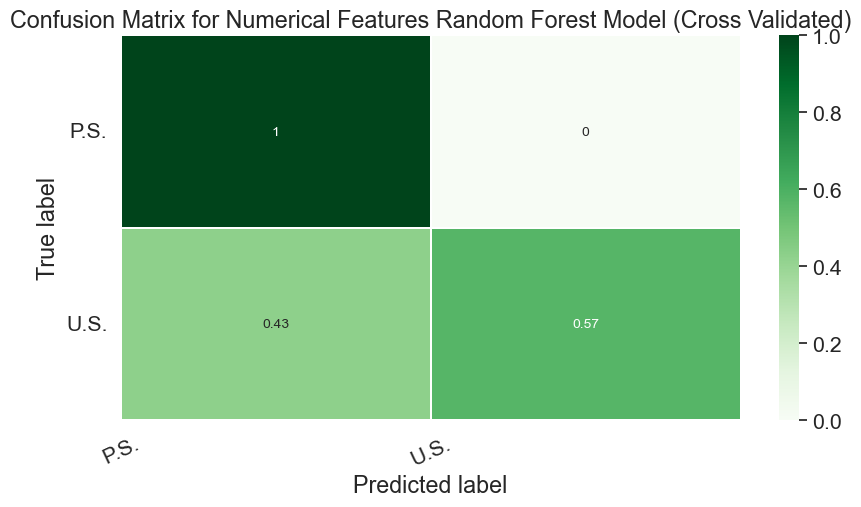

In [40]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (10,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (Cross Validated)')
plt.savefig('Confusion Matrix for Numerical Features Random Forest Model CV.png')
plt.show()

In [41]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.96      1.00      0.98       299
        U.S.       1.00      0.57      0.73        28

    accuracy                           0.96       327
   macro avg       0.98      0.79      0.85       327
weighted avg       0.96      0.96      0.96       327



#### 4. Out of Bag Evaluation Numeric Features

Accuracy: 0.9969418960244648


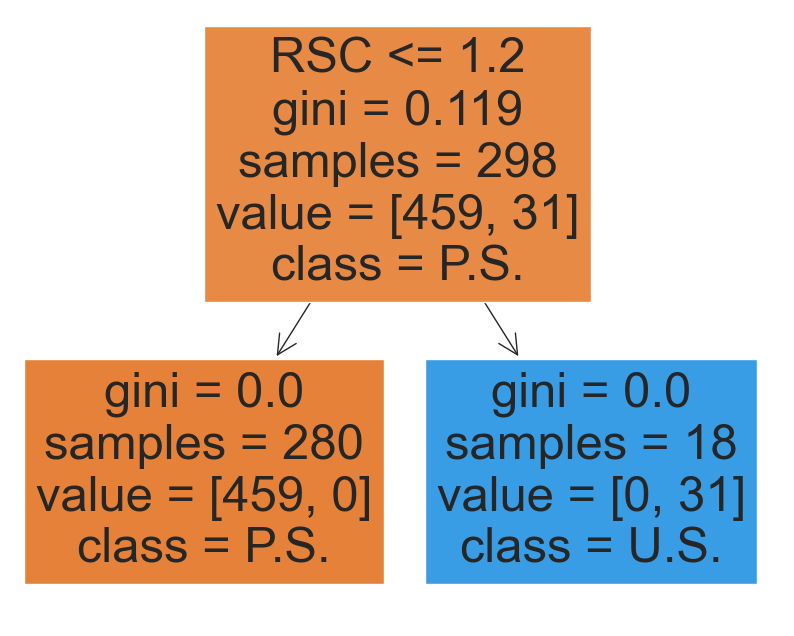

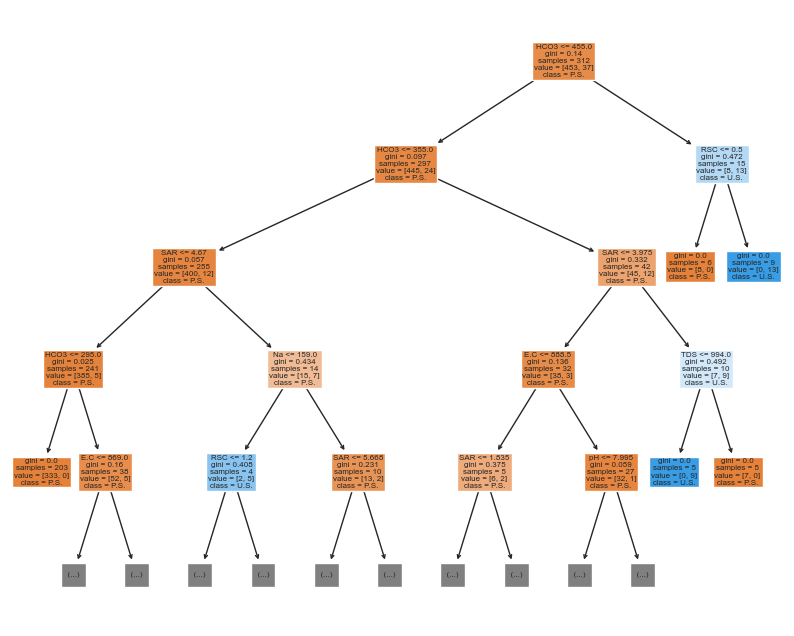

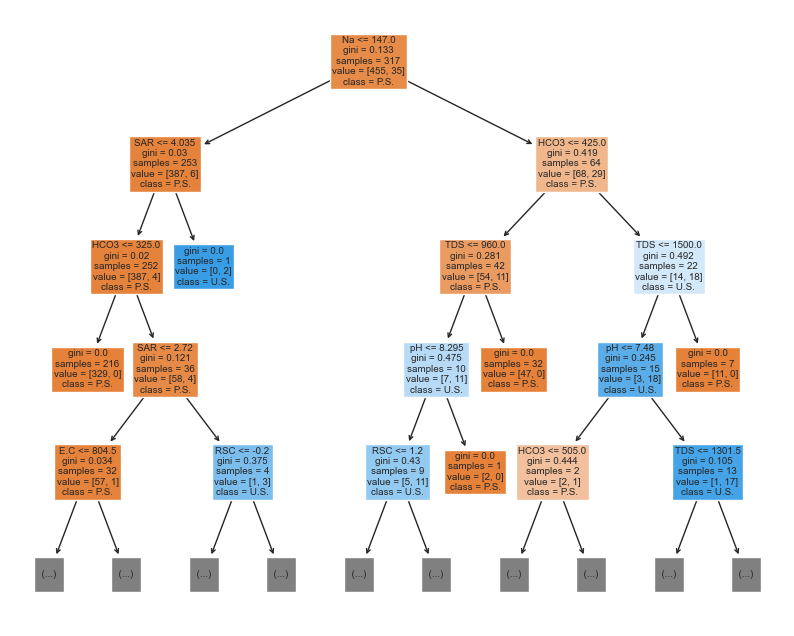

In [42]:
random.seed(10)
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    
    plt.figure(figsize=(10,8))
    plot_tree(tree, feature_names=list(X_train.columns), class_names=['P.S.', 'U.S.'], filled=True, max_depth=4)
    
    if i == 1:
        plt.savefig('Numeric Features OOB.png')
    
    plt.show()

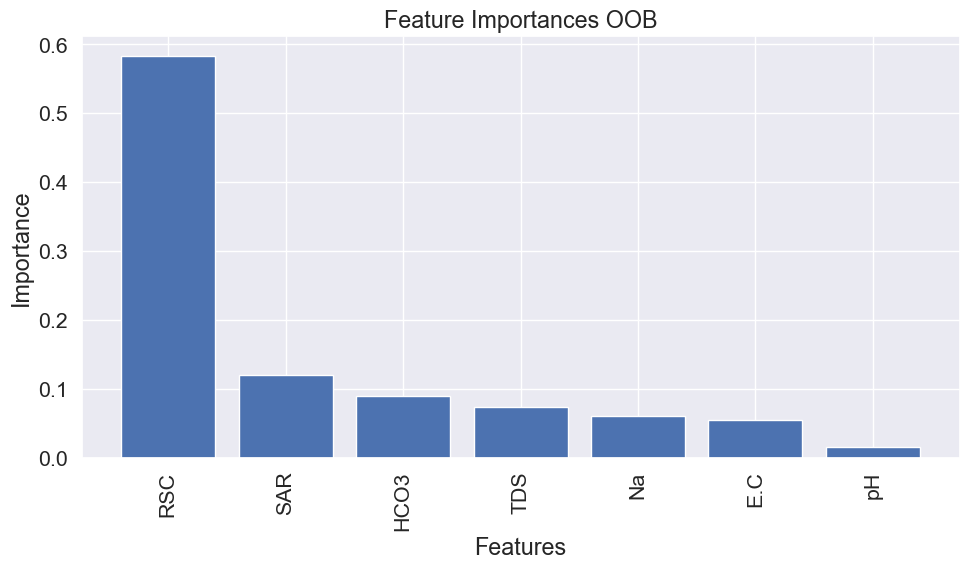

In [43]:
# Aggregate feature importances
importances = rf.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances OOB')
plt.tight_layout()
plt.savefig('Feature Importances OOB.png')
plt.show()

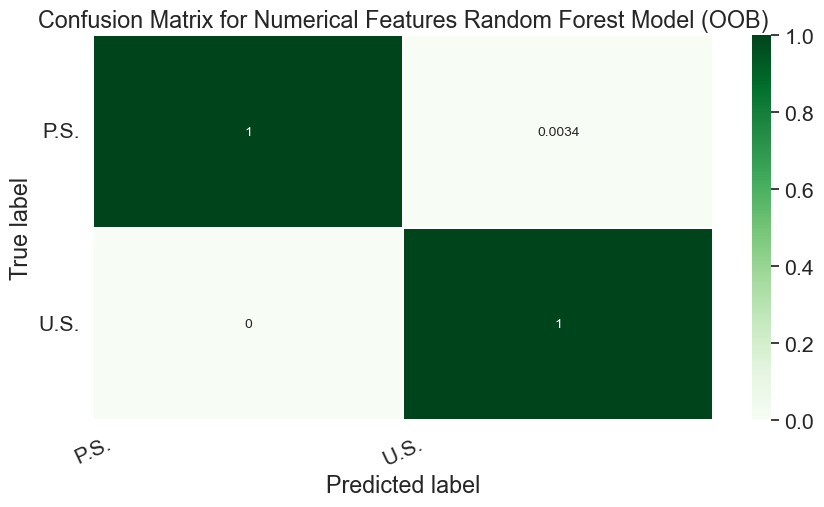

In [44]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (10,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (OOB)')
plt.savefig('Confusion Matrix for Numerical Features Random Forest Model OOB.png')
plt.show()

In [45]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       297
        U.S.       0.97      1.00      0.98        30

    accuracy                           1.00       327
   macro avg       0.98      1.00      0.99       327
weighted avg       1.00      1.00      1.00       327

